# Pipeline for new Molecules

In [1]:
import pandas as pd 
import numpy as np
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, DotProduct, WhiteKernel, RationalQuadratic

## 1. Generate SOAP Desciptors

In [2]:
from dscribe.descriptors import SOAP
import ase
import matplotlib.pyplot as plt
import ase.io
import ase.io.xyz
import numpy as np
import sklearn
from ase.build import molecule
from ase.io import read
from ase.visualize import view
structures=[]
### Read xyz files
Ethanol = read("Ethanol.xyz")
Butane = read("Butane.xyz")
Difluoroethane = read("Difluoroethane.xyz")
Ethane = read("Ethane.xyz")
Phosphineborane = read("Phosphineborane.xyz")
# define all possible funcionals
all_Functionals=['BP86_D3','PBE_D3','rPBE_D3','revPBE_D3','BLYP_D3','OLYP_D3','B97_D','B97_D3',
'BP86_D4','BLYP_D4','PBEMBDrsSC','TPSS_D3','M06L_D3','revTPSS_D3','SCAN_D3','r2SCAN_D4',
'TPSS_D4','B3LYP_D3','PBE0_D3','B3LYP_D4','PBE0_D4','PBE0MBDrsSC','M06_D30','M06_2X_D30',
'TPSSH_D3','TPSSH_D4','CAM_B3LYP_D3','CAM_B3LYP_D4']
# define functionals for the prediction (in this case the same as in testset II)
Functional_names = ["B3LYP_D3","BLYP_D3","BP86_D3","PBE_D3","B3LYP_D3","PBE_D3","SCAN_D3","TPSS_D3","BLYP_D3","PBE_D3","r2SCAN_D4","B3LYP_D3","PBE_D3","SCAN_D3"]


# create number according to the functional used
functional_number=[]
for i in range(len(all_Functionals)):
    functional_number.append(i)
dict_func_numb = dict(zip(all_Functionals, functional_number))

functional_number_new = []
for functionals in Functional_names:
    functional_number_new.append(dict_func_numb[functionals])

# Define atoms participating in bond
positions = [[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1],[0,1]]

structures = [Butane,Butane,Butane,Butane,Difluoroethane,Difluoroethane,Difluoroethane,Difluoroethane,Ethanol,Ethanol,Ethanol,Phosphineborane,Phosphineborane,Phosphineborane]
species = ['Ag', 'Cl', 'Cu', 'B', 'Au', 'H', 'C', 'F', 'O', 'N','P']

rcut = 3 # cut off for local region in A
nmax = 6 # max num of radial basis functions
lmax= 8 # max num of angular degree of spherical harmonics  
soap = SOAP(
    species=species,
    periodic=False,
    rcut=rcut,
    nmax=nmax,
    lmax=lmax,
    average="outer",
    sparse=False,
)

feature_vectors = soap.create(structures, positions=positions, n_jobs=1)

## 2. Perform PCA

           PC0         PC1         PC2  Functional Number
0   497.345511  317.698595   29.204545                 17
1   497.345511  317.698595   29.204545                  4
2   497.345511  317.698595   29.204545                  0
3   497.345511  317.698595   29.204545                  1
4    60.462207  123.968258  110.946482                 17
5    60.462207  123.968258  110.946482                  1
6    60.462207  123.968258  110.946482                 14
7    60.462207  123.968258  110.946482                 11
8   288.899096  170.402570    7.652962                  4
9   288.899096  170.402570    7.652962                  1
10  288.899096  170.402570    7.652962                 15
11  315.119475   54.120426   -2.396575                 17
12  315.119475   54.120426   -2.396575                  1
13  315.119475   54.120426   -2.396575                 14


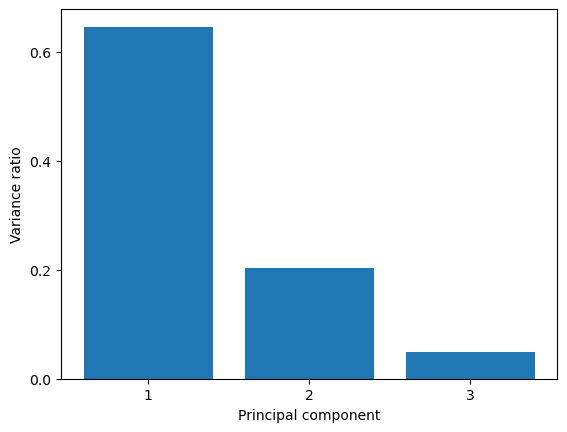

<Figure size 700x500 with 0 Axes>

In [3]:
import pickle
filename = 'PCA_SOAP_bonding_only_w_P.sav'
# load the model
pca_reload = pickle.load(open(filename, 'rb'))

descriptor = feature_vectors
from sklearn.decomposition import PCA

X= descriptor
pca=pca_reload
X_new = pca.transform(X)
pcs = np.arange(len(pca.explained_variance_ratio_))+1
size=22
params = {'legend.fontsize': 'large',
          'figure.figsize': (7,5),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 10}
plt.bar(pcs, pca.explained_variance_ratio_)
plt.xlabel("Principal component")
plt.xticks(pcs)
plt.ylabel("Variance ratio")
plt.rcParams.update(params)
plt.savefig("PCA_variance_bonding_SOAP.png", dpi=300, transparent=True, bbox_inches="tight")
fig=plt.figure()
type(pca.explained_variance_ratio_)

pcas = pd.DataFrame(pca.transform(X), columns=["PC%i" % i for i in range(3)])
functional_number = []
pcas.insert(3, "Functional Number", functional_number_new)
print (pcas)

## 3. Predict new Energies

In [4]:
#print (new_molecules)
filename = 'final_KRR_regression_w_P.sav'
KRR_regr = pickle.load(open(filename, 'rb'))

pcas = pcas.rename(columns={'PC0': 'PC1', 'PC1': 'PC2', 'PC2': 'PC3'})
EDA_predict = KRR_regr.predict(pcas)

EDA_pred = pd.DataFrame(EDA_predict,columns=["E_Pauli","E_Elek","E_Orb","E_tot","E_Disp", "E_rel_Elek", "E_rel_Disp"])
EDA_pred = pd.concat([pcas,EDA_pred],axis=1)
print (EDA_pred)

           PC1         PC2         PC3  Functional Number     E_Pauli  \
0   497.345511  317.698595   29.204545                 17  198.745271   
1   497.345511  317.698595   29.204545                  4  203.285540   
2   497.345511  317.698595   29.204545                  0  195.729099   
3   497.345511  317.698595   29.204545                  1  194.806589   
4    60.462207  123.968258  110.946482                 17  588.518180   
5    60.462207  123.968258  110.946482                  1  581.692399   
6    60.462207  123.968258  110.946482                 14  573.758627   
7    60.462207  123.968258  110.946482                 11  579.322396   
8   288.899096  170.402570    7.652962                  4  652.428472   
9   288.899096  170.402570    7.652962                  1  626.932986   
10  288.899096  170.402570    7.652962                 15  607.161930   
11  315.119475   54.120426   -2.396575                 17  441.589559   
12  315.119475   54.120426   -2.396575             

## 4. Classify 

In [5]:
import pickle
# Normalization 
test_train_I = pd.read_csv("test_train_I.csv")
MIN = test_train_I.min()
MAX = test_train_I.max()
EDA_pred_norm = (EDA_pred-MIN)/(MAX-MIN)
filename = 'final_MLPClassifier_4_classes_w_XC.sav'
MLPC = pickle.load(open(filename, 'rb'))
class_pred = MLPC.predict(EDA_pred_norm.loc[:,"Functional Number":"E_rel_Disp"])
print ("Predicted bond classes:", class_pred)
print ("Bond class 1: covalent")
print ("Bond class 2: main-group donor-acceptor")
print ("Bond class 3: transitionmetal donor-acceptor")
print ("Bond class 4: H-bound")

Predicted bond classes: [2 4 4 4 1 1 1 1 1 1 1 2 2 2]
Bond class 1: covalent
Bond class 2: main-group donor-acceptor
Bond class 3: transitionmetal donor-acceptor
Bond class 4: H-bound
